# Comparison
This Demonstration compares performance of reinforcement learning models across seperate seperate tasks. 

* In every task objective is to go to the goal location as quickly as possible
* Agent learns reward functions and a mapping function for each task. A mapping function is a relationship
between primitive actions and cardinal movements (N, S, E, W), and is learned in place of a transition function. We assume an agent knowns cardinal movements
* Each task is associated with a "context" and the state of the agent can be defined formally as a tuple of it's location in space and it's context:  
s = (x, y, c)
* Task Set Agent: Assumes contexts can be clustered together and clusters share both 1) Reward function and 2) Mapping
* Independent Clustering Agent: Assumes Reward functions and Mappings can be clustered indpendendly of each other based on their contexts

In [6]:
%matplotlib inline
import copy
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from Agents import Task, TaskSetAgent, IndependentClusterAgent, FlatAgent
from utils import randomize_order, make_task

In [7]:
# define all of the task parameters
grid_world_size = (6, 6)

map_0 = {0: u'left', 1: u'up', 2: u'down', 3: u'right'}
map_1 = {4: u'up', 5: u'left', 6: u'right', 7: u'down'}

goal_0 = (0, 0)
goal_1 = (0, 5)
goal_2 = (5, 0)
goal_3 = (5, 5)
context_goals = [goal_0, goal_1, goal_2, goal_3, goal_0, goal_3]

start_locations = [(x, y) for x in range(grid_world_size[0]) for y in range(grid_world_size[1])]
for g in set(context_goals):
    start_locations.remove(g)

context_maps = [map_0, map_0, map_0, map_0, map_1, map_1]
context_balance = [2, 2, 6, 6, 4, 4]

hazard_rates = [0.5, 0.67, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

list_goal_priors = [(0, 0), (0, 5), (5, 0), (5, 5)]

task_kwargs = dict(
    context_balance=context_balance,
    context_goals=context_goals,
    context_maps=context_maps,
    hazard_rates=hazard_rates,
    start_locations=start_locations,
    grid_world_size=grid_world_size,
    list_goal_priors=list_goal_priors
)


# Define a function to Simluate the Models:
def simulate(agent_class, simulation_number, task_kwargs, agent_kwargs=None):
    _kwargs = copy.copy(task_kwargs)
    del _kwargs['list_goal_priors']
    task = make_task(**_kwargs)
    if agent_kwargs is not None:
        agent = agent_class(task, **agent_kwargs)
    else:
        agent = agent_class(task)
    agent.set_reward_prior(task_kwargs['list_goal_priors'])

    results = agent.generate()
    results['Simulation Number'] = [simulation_number] * len(results)
    results['Cumulative Steps Taken'] = results['n actions taken'].cumsum()

    return results

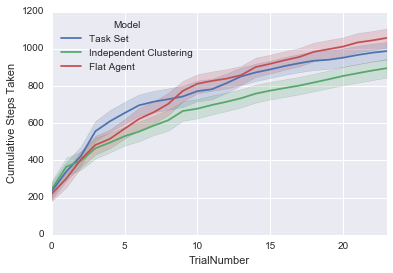

In [8]:
n_sim = 25

resultsTS = pd.concat([simulate(TaskSetAgent, ii, task_kwargs) for ii in range(n_sim)])
resultsIC = pd.concat([simulate(IndependentClusterAgent, ii, task_kwargs) for ii in range(n_sim)])
resultsFL = pd.concat([simulate(FlatAgent, ii, task_kwargs) for ii in range(n_sim)])

resultsTS['Model'] = ['Task Set'] * len(resultsTS)
resultsIC['Model'] = ['Independent Clustering'] * len(resultsIC)
resultsFL['Model'] = ['Flat Agent'] * len(resultsFL)
results = pd.concat([resultsTS, resultsIC, resultsFL])


# define the parameters to plot the results
plot_kwargs = dict(
    time='TrialNumber',
    value='Cumulative Steps Taken',
    data=results[results['In goal']], 
    unit='Simulation Number',
    condition='Model'
)

sns.tsplot(**plot_kwargs)

We can also define other task enviornments. Here, we define the same task but on a gridworld with 3x4 grid 

In [9]:
# define all of the task parameters here
grid_world_size = (3, 4)

map_0 = {0: u'left', 1: u'up', 2: u'down', 3: u'right'}
map_1 = {4: u'up', 5: u'left', 6: u'right', 7: u'down'}

goal_0 = (0, 0)
goal_1 = (0, 3)
goal_2 = (2, 0)
goal_3 = (2, 3)
context_goals = [goal_0, goal_1, goal_2, goal_3, goal_0, goal_3]

start_locations = [(x, y) for x in range(grid_world_size[0]) for y in range(grid_world_size[1])]
for g in set(context_goals):
    start_locations.remove(g)

context_maps = [map_0, map_0, map_0, map_0, map_1, map_1]
context_balance = [2, 2, 6, 6, 4, 4]

hazard_rates = [0.5, 0.67, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

list_goal_priors = [(0, 0), (0, 3), (2, 0), (2, 3)]

task_kwargs = dict(
    context_balance=context_balance,
    context_goals=context_goals,
    context_maps=context_maps,
    hazard_rates=hazard_rates,
    start_locations=start_locations,
    grid_world_size=grid_world_size,
    list_goal_priors=list_goal_priors
)

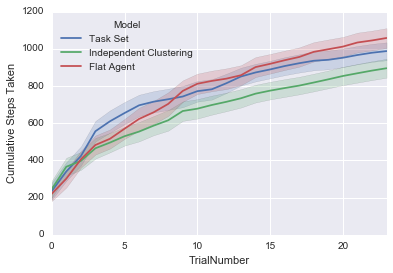

In [10]:
n_sim = 25

resultsTS = pd.concat([simulate(TaskSetAgent, ii, task_kwargs) for ii in range(n_sim)])
resultsIC = pd.concat([simulate(IndependentClusterAgent, ii, task_kwargs) for ii in range(n_sim)])
resultsFL = pd.concat([simulate(FlatAgent, ii, task_kwargs) for ii in range(n_sim)])

resultsTS['Model'] = ['Task Set'] * len(resultsTS)
resultsIC['Model'] = ['Independent Clustering'] * len(resultsIC)
resultsFL['Model'] = ['Flat Agent'] * len(resultsFL)
results = pd.concat([resultsTS, resultsIC, resultsFL])


results = pd.concat([resultsTS, resultsIC])
sns.tsplot(**plot_kwargs)